In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import win32gui
import pickle
import mss
import random
from PIL import Image
from imutils import grab_contours

In [4]:
"""
Lets supopse we have a poker game running and want to have a log of every action taken on table.
Every move can be deduced by catching turn shifts and pot changes.
This is an universal soultion for remembering and recognizing patterns used by game site.
"""

GAME_WINDOW_NAME = ""

In [3]:
# handle game window

def winEnumHandler(hwnd, ctx):
    global POKS_WINDOW
    if win32gui.IsWindowVisible(hwnd):
        name = win32gui.GetWindowText(hwnd)
        #print (name)
        if name.endswith('$'): # casual ending for game windows 
            GAME_WINDOW_NAME = name
            print("\n-found-\n")

win32gui.EnumWindows(winEnumHandler, None)

In [5]:
# take screenshot of game window

def shot(fg=False, save=True): # optionally set to foreground and save
    window_title = GAME_WINDOW_NAME
    if window_title:
        hwnd = win32gui.FindWindow(None, window_title)
        if hwnd:
            if fg:
                win32gui.SetForegroundWindow(hwnd)
            x_b, y_b, x1, y1 = win32gui.GetWindowRect(hwnd)
            #print(x_b,y_b,x1,y1)
            if location == "full":
                x, y = x_b, y_b
                x1, y1 =  x_b, y_b  
            #print(x,y,x1,y1)
            region = {'top': y, 'left': x, 'width': 808, 'height': 585}

            #print(region)
            img = mss.mss().grab(region)

            table_np = np.array(img)

            if(save):
                x = random.randint(1,100)
                plt.imsave(f"../sct{x}.png", table_np)

            # return it as numpy array for live game analyzing
            return table_np
        else:
            print('Window not found!')

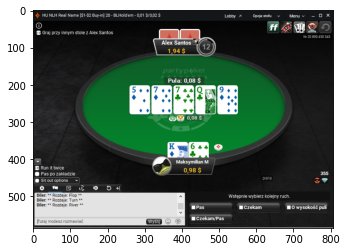

In [6]:
# plot saved image

img = Image.open("../sct7.png")
table_np = np.array(img)
plt.imshow(table_np)

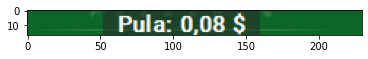

In [7]:
# cut pot

pot_coordinates = (300,530,180,197)
x, x2, y, y2 = pot_coordinates
pot_cut = table_np[y:y2, x:x2]
plt.imshow(pot_cut)

In [8]:
# get array of numpy arrays representing croped digits

def extract_digits(cut_np):
    # RGBX (live mss format)
    # crop_gray = np.dot(cut_np[...,:4], [0.299, 0.587, 0.114, 0.0]).astype(np.uint8) 
    
    # convert to binary
    crop_gray = np.dot(cut_np[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8) #RGB
    thresh = cv2.threshold(crop_gray,180,255,cv2.THRESH_BINARY)[1]
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = grab_contours(cnts)
    digit_imgs = []
    # loop over the digit area candidates
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        if (h==11 and w!=9): # average
            cropped = thresh[y:y+h, x:x+w] # we only need tresholded image
            #cropped = crop_gray[y:y+h, x:x+w]
            digit_imgs.append(cropped)
    return digit_imgs # from right to left


(11, 8)


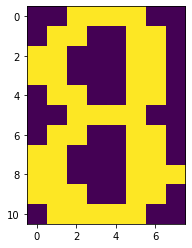

In [9]:
croped = extract_digits(pot_cut)
print(croped[0].shape) # last pot digit
plt.imshow(croped[0])

In [10]:
# coordinates of cards

def cut(pos, idx, table_np):
    """Cutter of areas of interest"""

    # cards positions
    y0 = 201
    if(pos==1): # table
        x0 = 258
    elif(pos==2):
        x0 = 317
    elif(pos==3):
        x0 = 376
    elif(pos==4):
        x0 = 435
    elif(pos==5):
        x0 = 494
    elif(pos==6): # hand
        x0 = 360
        y0 = 353
    elif(pos==7):    
        x0 = 416
        y0 = 353

    # card property
    if(idx==1): # symbol
        dx = 7
        dy = 4
        w = 12
        h = 18

    if(idx==2): # color
        dx = 7
        dy = 26
        w = 12
        h = 12

    if(idx==3): # point (presence of card)
        dx = 4
        dy = 4
        w = 1
        h = 1

    x1 = x0+dx
    x2 = x0+dx+w
    y1 = y0+dy
    y2 = y0+dy+h

    cut_np = table_np[y1:y2, x1:x2]
    return cut_np

(18, 12, 3)


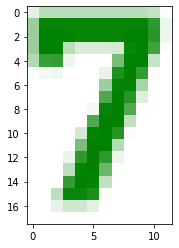

In [11]:
symbol_np = cut(3, 1, table_np)
print(symbol_np.shape)
plt.imshow(symbol_np)

In [12]:
def myThresh(img_np):
    """Universal threshold nautralizing color influence on image"""
    raw = img_np[:,:,0].copy() # reduce dimmensions to 1
    for i in range(img_np.shape[0]): # for every pixel
        for j in range(img_np.shape[1]):
            if sum(img_np[i,j,:]) == 255*img_np.shape[2]: # 255 on every dimmension
                raw[i][j] = 255  # leave the brightest
            else:
                raw[i][j] = 0  # dim the rest
    return raw

(18, 12)


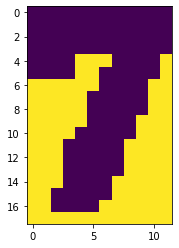

In [13]:
raw_symbol_np = myThresh(symbol_np)
print(raw_symbol_np.shape)
plt.imshow(raw_symbol_np) 

In [14]:
def mse(imageA, imageB):
	"""Sum of the squared difference between the two images"""
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# the lower the error, the more "similar" images
	return err

In [27]:
# main functions searching for saved patterns and creating them

def find_symbol(cut_np):
    """Function comparing symbol with those saved under symbols directory
    and saving it if new"""
    found = False
    for filename in os.listdir('symbols'): # browse pickled arrays of symbols
        with open(f"symbols/{filename}", 'rb') as f:
            if not found:
                img_np = pickle.load(f)
                if mse(img_np, cut_np) < 100: # compare current cut with saved
                    found = True
                    print(f"symbol found: {filename}")

    # if it didn't match any saved template
    if not found:
        x = random.randint(1,100000)
        print(f"creating...symbol{x}")
        with open(f"symbols/symbol{x}.pkl", 'wb') as f:
            pickle.dump(cut_np, f) # pickle it with random name (change it later)


# similar but for colors
def find_color(cut_np):
    found = False
    for filename in os.listdir('colors'):
        with open(f"colors/{filename}", 'rb') as f:
            img_np = pickle.load(f)
            if mse(img_np, cut_np) < 100:
                found = True
                print(f"color found: {filename}")

    if not found:
        x = random.randint(1,100000)
        print(f"creating...color{x}")
        with open(f"colors/color{x}.pkl", 'wb') as f: 
            pickle.dump(cut_np, f) 

# and pot digits
def read_pot(croped):
    for cut_np in croped:
        print("\npot_digit:")
        found = False
        for filename in os.listdir('digits'):
            with open(f"digits/{filename}", 'rb') as f:
                if not found:
                    img_np = pickle.load(f)
                    try:
                        if mse(img_np, cut_np) < 100:
                            found = True
                            print(f"digit found {filename}")
                    except ValueError:
                        pass  # different size of digits
                        #print("skipping...")
                
        if not found:
            x = random.randint(1,100000)
            print(f"creating..{x}")
            with open(f"digits/digit{x}.pkl", 'wb') as f: 
                pickle.dump(cut_np, f)         

In [38]:
# check for saved card - 7
find_symbol(raw_symbol_np)

symbol found: seven.pkl


In [39]:
# check for first time seen card - 9
symbol_np = cut(5, 1, table_np)
raw_color_np = myThresh(symbol_np)
find_symbol(raw_color_np)

creating...symbol32704


In [40]:
# see what was saved
with open('symbols/symbol32704.pkl', 'rb') as f:
    pickled_array = pickle.load(f)
    print(pickled_array)

[[255 255 255   0   0   0   0   0 255 255 255 255]
 [255   0   0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0   0   0 255 255]
 [  0   0   0   0   0   0   0   0   0   0   0 255]
 [  0   0   0   0 255 255   0   0   0   0   0 255]
 [  0   0   0   0 255 255 255   0   0   0   0 255]
 [  0   0   0   0 255 255 255   0   0   0   0 255]
 [  0   0   0   0 255 255 255   0   0   0   0 255]
 [  0   0   0   0   0   0   0   0   0   0   0 255]
 [  0   0   0   0   0   0   0   0   0   0   0 255]
 [255   0   0   0   0   0   0   0   0   0   0 255]
 [255 255 255 255 255 255   0   0   0   0   0 255]
 [255 255 255 255 255   0   0   0   0   0 255 255]
 [255 255   0   0   0   0   0   0   0   0 255 255]
 [255   0   0   0   0   0   0   0   0 255 255 255]
 [255   0   0   0   0   0   0   0 255 255 255 255]
 [255   0   0   0   0   0   0 255 255 255 255 255]
 [255 255   0   0 255 255 255 255 255 255 255 255]]


In [41]:
def collect_data(table_np):

    # loop over every card currently on table
    for card_num in range(1,8):
        if cut(card_num, 3, table_np)[0][0][0] > 200: # if chosen presence pixel is white
            print(f"\ncard no. {card_num}:")

            symbol = cut(card_num, 1, table_np) # get symbol
            find_symbol(myThresh(symbol)) # search for it in saved

            color = cut(card_num, 2, table_np) # get color
            find_color(myThresh(color)) # search for it in saved

        else: print(f"\ncard no. {card_num}: hidden")

    # check pot too
    pot_cut = table_np[180:197, 300:530]
    croped = extract_digits(pot_cut)
    read_pot(croped)


In [42]:
collect_data(table_np)


card no. 1:
creating...symbol2641
creating...color85351

card no. 2:
symbol found: seven.pkl
color found: color85351.pkl

card no. 3:
symbol found: seven.pkl
creating...color64833

card no. 4:
creating...symbol92221
color found: color64833.pkl

card no. 5:
symbol found: symbol32704.pkl
color found: color85351.pkl

card no. 6:
creating...symbol19137
color found: color85351.pkl

card no. 7:
creating...symbol78036
color found: color64833.pkl

pot_digit:
creating..63167

pot_digit:
creating..45089

pot_digit:
digit found digit45089.pkl


In [43]:
# the only symbol found is seven, because it is the only one that was previously saved
# every other is saved now under random name

# lets check that again, now every should be found
collect_data(table_np)


card no. 1:
symbol found: symbol2641.pkl
color found: color85351.pkl

card no. 2:
symbol found: seven.pkl
color found: color85351.pkl

card no. 3:
symbol found: seven.pkl
color found: color64833.pkl

card no. 4:
symbol found: symbol92221.pkl
color found: color64833.pkl

card no. 5:
symbol found: symbol32704.pkl
color found: color85351.pkl

card no. 6:
symbol found: symbol19137.pkl
color found: color85351.pkl

card no. 7:
symbol found: symbol78036.pkl
color found: color64833.pkl

pot_digit:
digit found digit63167.pkl

pot_digit:
digit found digit45089.pkl

pot_digit:
digit found digit45089.pkl


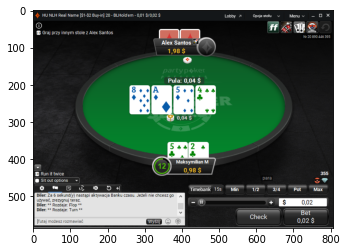

In [44]:
# analyze new table
img = Image.open("../sct2.png")
table_np = np.array(img)
plt.imshow(table_np)

In [45]:
# thera are couple cards and digits which are seen first time
collect_data(table_np)


card no. 1:
creating...symbol45965
color found: color85351.pkl

card no. 2:
creating...symbol94864
color found: color85351.pkl

card no. 3:
symbol found: symbol2641.pkl
color found: color85351.pkl

card no. 4:
creating...symbol31324
color found: color64833.pkl

card no. 5: hidden

card no. 6:
symbol found: symbol2641.pkl
color found: color64833.pkl

card no. 7:
creating...symbol36020
color found: color64833.pkl

pot_digit:
creating..79997

pot_digit:
digit found digit45089.pkl

pot_digit:
digit found digit45089.pkl


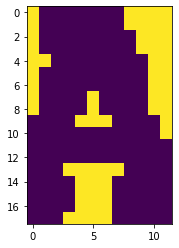

In [47]:
# symbol on card no. 2 was created (symbol94864.pkl)
with open('symbols/symbol94864.pkl', 'rb') as f:
    pickled_array = pickle.load(f)
    plt.imshow(pickled_array)

In [48]:
# and third pot digit - 4 (digit79997)
with open('digits/digit79997.pkl', 'rb') as f:
    pickled_array = pickle.load(f)
    print(pickled_array)

[[  0   0   0   0 255 255 255   0]
 [  0   0   0 255 255 255 255   0]
 [  0   0   0 255 255 255 255   0]
 [  0   0 255 255 255 255 255   0]
 [  0 255 255   0 255 255 255   0]
 [  0 255 255   0 255 255 255   0]
 [255 255   0   0 255 255 255   0]
 [255 255 255 255 255 255 255 255]
 [  0   0   0   0 255 255 255   0]
 [  0   0   0   0 255 255 255   0]
 [  0   0   0   0 255 255 255   0]]


In [ ]:
# the point of the above is that after couple screenshots (including every possible card symbol and pot
# digit) we have every pattern saved. It might be helpful for example after changing fonts or templates
# of cards in game site